In [1]:
from datetime import datetime
import os
import sys

import torch
from peft import (
    LoraConfig,
    get_peft_model,
    get_peft_model_state_dict,
    prepare_model_for_kbit_training,
    set_peft_model_state_dict,
)
from transformers import AutoTokenizer, AutoModelForCausalLM, TrainingArguments, Trainer, DataCollatorForSeq2Seq
from datasets import load_dataset

/home/rrsood/miniconda3/envs/codegen/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset("mbpp", split="train")
train_dataset = dataset.train_test_split(test_size=0.1)["train"]
eval_dataset = dataset.train_test_split(test_size=0.1)["test"]

In [3]:
base_model = "bigcode/starcoder2-7b"
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    load_in_8bit=True,
    torch_dtype=torch.float16,
    device_map="auto",
)
tokenizer = AutoTokenizer.from_pretrained("bigcode/starcoder2-7b")

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
Loading checkpoint shards: 100%|██████████| 3/3 [00:11<00:00,  3.94s/it]


In [6]:
# Tokenizer
tokenizer.add_eos_token = True
tokenizer.pad_token_id = 0
tokenizer.padding_side = "left"

def tokenize(prompt):
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=512,
        padding=False,
        return_tensors=None)

    result["labels"] = result["input_ids"].copy()
    return result

def generate_and_tokenize_prompt(data_point):
    code_prompt = f"{data_point['code']}"

    test_prompt = """\n
def test():
    # Tests the above function
"""
    for test in data_point['test_list']:
        test_prompt += "  "
        test_prompt += test
        test_prompt += "\n"

    full_prompt = code_prompt + test_prompt

    return tokenize(full_prompt)

In [7]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Map: 100%|██████████| 336/336 [00:00<00:00, 1374.83 examples/s]


In [8]:
# Setting up LoRA
model.train() # put model back into training mode
model = prepare_model_for_kbit_training(model)

config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=[
    "q_proj",
    "k_proj",
    "v_proj",
    "o_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, config)

In [9]:
wandb_project = "starcoder2_testcases"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

In [10]:
if torch.cuda.device_count() > 1:
    # keeps Trainer from trying its own DataParallelism when more than 1 gpu is available
    model.is_parallelizable = True
    model.model_parallel = True

In [12]:
batch_size = 32
per_device_train_batch_size = 16
gradient_accumulation_steps = batch_size // per_device_train_batch_size
output_dir = "starcoder2_finetune"

training_args = TrainingArguments(
        per_device_train_batch_size=per_device_train_batch_size,
        gradient_accumulation_steps=gradient_accumulation_steps,
        warmup_steps=50,
        max_steps=400,
        learning_rate=3e-4,
        fp16=True,
        logging_steps=1,
        optim="adamw_torch",
        evaluation_strategy="steps", # if val_set_size > 0 else "no",
        save_strategy="steps",
        eval_steps=20,
        save_steps=20,
        output_dir=output_dir,
        # save_total_limit=3,
        load_best_model_at_end=False,
        # ddp_find_unused_parameters=False if ddp else None,
        group_by_length=True, # group sequences of roughly the same length together to speed up training
        report_to="wandb", # if use_wandb else "none",
        run_name=f"starcoder2-{datetime.now().strftime('%Y-%m-%d-%H-%M')}", # if use_wandb else None,
    )

trainer = Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=training_args,
    data_collator=DataCollatorForSeq2Seq(
        tokenizer, pad_to_multiple_of=8, return_tensors="pt", padding=True
    ),
)

Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [13]:
trainer.train()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rrsood (rsood). Use `wandb login --relogin` to force relogin


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/home/rrsood/miniconda3/envs/codegen/lib/python3.12/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/rrsood/miniconda3/envs/codegen/lib/python3.12/site-packages/bitsandbytes/autograd/_functions.py:322: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Step,Training Loss,Validation Loss


KeyboardInterrupt: 

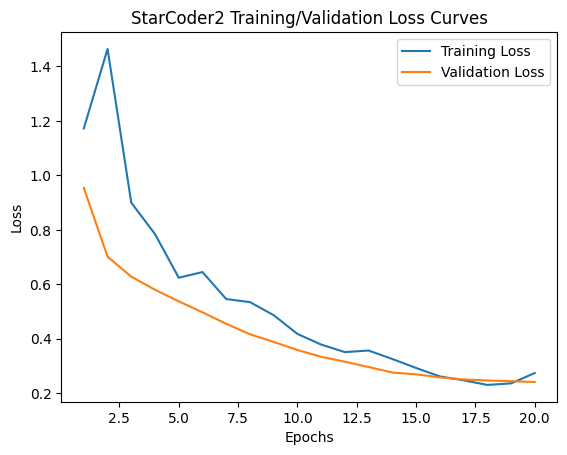

In [1]:
# Plots
import matplotlib.pyplot as plt
epochs = [i for i in range(1, 21)]
train_loss = [1.1725, 1.4643, 0.8996, 0.7844, 0.6242, 0.6449, 0.5458, 0.5346, 0.4866, 0.4178, 0.3787, 0.351, 0.3568, 0.3257, 0.2928, 0.2617, 0.2475, 0.2305, 0.2361, 0.2741]
eval_loss = [0.9539, 0.7014, 0.6279, 0.5799, 0.5374, 0.4971, 0.455, 0.4166, 0.3883, 0.3588, 0.3338, 0.3157, 0.2962, 0.2761, 0.2694, 0.2584, 0.2508, 0.2468, 0.2442, 0.2413]
plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, eval_loss, label="Validation Loss")
plt.title("StarCoder2 Training/Validation Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

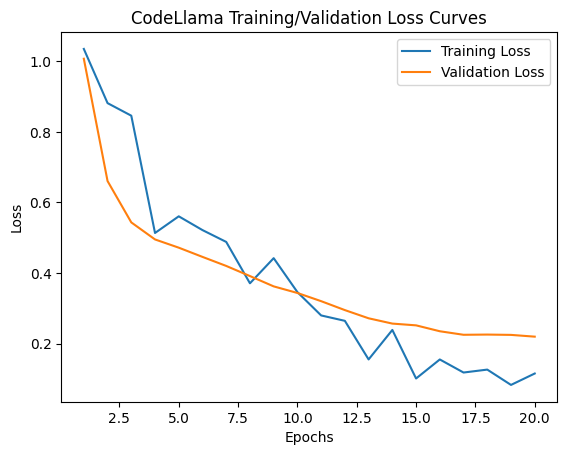

In [2]:
epochs = [i for i in range(1, 21)]
train_loss = [1.0348, 0.8813, 0.8457, 0.5135, 0.5607, 0.5217, 0.4882, 0.371, 0.4422, 0.346, 0.28, 0.2647, 0.1554, 0.2389, 0.1014, 0.1553, 0.1183, 0.1266, 0.0832, 0.1155]
eval_loss = [1.007, 0.6606, 0.5435, 0.4952, 0.4719, 0.4458, 0.4202, 0.3915, 0.3623, 0.3436, 0.3204, 0.2951, 0.2719, 0.2569, 0.2519, 0.2352, 0.2252, 0.2258, 0.2249, 0.2199]
plt.plot(epochs, train_loss, label="Training Loss")
plt.plot(epochs, eval_loss, label="Validation Loss")
plt.title("CodeLlama Training/Validation Loss Curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()